# Chapter 6 - Linear Model Selection and Regularization

### 6.5.1 Subset Selection Methods
Here we implement methods that reduce the number of parameters in a
model by restricting the model to a subset of the input variables.

In [1]:
#!pip install ISLP
#!pip install l0bnb

In [2]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.cross_decomposition import PLSRegression
from ISLP.models import (Stepwise, sklearn_selected, sklearn_selection_path)

from l0bnb import fit_path

In [35]:
import warnings
warnings.filterwarnings("ignore")

#### Forward Selection
We will apply the forward-selection approach to the Hitters data. We wish
to predict a baseball player’s Salary on the basis of various statistics associated with performance in the previous year.

In [4]:
# Read data
file = 'data/Hitters.csv'
hitters = pd.read_csv(file)
hitters.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


In [5]:
hitters = hitters.drop(columns=['Unnamed: 0'])

hitters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    object 
dtypes: float64

In [6]:
# Check for NA values in the DataFrame
na_counts = hitters.isna().sum()
na_counts

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

In [7]:
# Filter columns that contain NA values
columns_with_na = na_counts[na_counts > 0]

print(columns_with_na)

Salary    59
dtype: int64


In [8]:
hitters = hitters.dropna()

hitters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 1 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 
dtypes: float64(1), 

In [9]:
hitters.shape

(263, 20)

In [10]:
# Create dummy variables for qualitative features
qual = ['League', 'Division', 'NewLeague']

hitters = pd.get_dummies(hitters, columns=qual)  # Create dummy variables for the specified qualitative columns in 'qual'

hitters = hitters.astype(int)                 # Convert boolean columns to 0 and 1

hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,PutOuts,Assists,Errors,Salary,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,...,632,43,10,475,0,1,0,1,0,1
2,479,130,18,66,72,76,3,1624,457,63,...,880,82,14,480,1,0,0,1,1,0
3,496,141,20,65,78,37,11,5628,1575,225,...,200,11,3,500,0,1,1,0,0,1
4,321,87,10,39,42,30,2,396,101,12,...,805,40,4,91,0,1,1,0,0,1
5,594,169,4,74,51,35,11,4408,1133,19,...,282,421,25,750,1,0,0,1,1,0


We first choose the best model using forward selection based on Cp. This score is not built in as a metric to sklearn. We therefore define a
function to compute it ourselves, and use it as a scorer. By default, sklear 
tries to maximize a score, hence our scoring function computes the negati e Cp
statistic.

In [11]:
def nCp(sigma2, estimator, X, Y):
    """
    Calculate the Negative Cp statistic.
    
    Parameters:
    sigma2 (float): The variance estimate of the error term.
    estimator (object): A fitted model with a 'predict' method.
    X (array-like): The feature matrix.
    Y (array-like): The target vector.

    Returns:
    float: The Negative Cp statistic value.
    """
    
    # Get the number of observations (n) and the number of features (p) from X
    n, p = X.shape
    
    # Use the estimator to predict the target values based on the feature matrix X
    Yhat = estimator.predict(X)
    
    # Calculate the residual sum of squares (RSS), which is the sum of squared differences between the actual and predicted values
    RSS = np.sum((Y - Yhat)**2)
    
    # Calculate and return the Negative Cp statistic, which is given by the formula:
    # -(RSS + 2 * p * sigma2) / n
    return -(RSS + 2 * p * sigma2) / n


We need to estimate the residual variance σ2, which is the first argument in our scoring function above. We will fit the biggest model, using all the
variables, and estimate σ2 based on its MSE.

In [12]:
# Fit a feature transformation model to the dataset, excluding the 'Salary' column
design = MS(hitters.columns.drop('Salary')).fit(hitters)

# Extract the target variable 'Salary' from the dataset and convert it to a NumPy array
Y = np.array(hitters['Salary'])

# Transform the dataset using the fitted transformation model to create feature matrix X
X = design.transform(hitters)

# Fit an Ordinary Least Squares (OLS) model to the transformed features (X) and target (Y)
sigma2 = OLS(Y, X).fit().scale

The function sklearn_selected() expects a scorer with just three arguments — the last three in the definition of nCp() above. We use the function
partial() first seen in Section 5.3.3 to freeze the first argument with our
estimate of σ2.

In [13]:
neg_Cp = partial(nCp, sigma2)

We can now use `neg_Cp()` as a scorer for model selection.

Along with a score we need to specify the search strategy. This is done through the object `Stepwise()` in the ISLP.models package. The method
`Stepwise.first_peak()` runs forward stepwise until any further additions to the model do not result in an improvement in the evaluation score. Similarly, the method `Stepwise.fixed_steps()` runs a fixed number of steps of stepwise search.

In [14]:
# Initialize the stepwise regression strategy
strategy = Stepwise.first_peak(  
    design,                      # Feature transformation model used for stepwise regression
    direction='forward',         # Specify forward selection direction for adding features
    max_terms=len(design.terms)  # Set the maximum number of terms to the number of features in the design
)

We now fit a linear regression model with Salary as outcome using forward selection. To do so, we use the function `sklearn_selected()` from the
sklearn_ISLP.models package. This takes a model from statsmodels along with a selected()
search strategy and selects a model with its fit method. Without specifying a scoring argument, the score defaults to MSE, and so all 19 variables
will be selected (output not shown).

In [15]:
hitters_MSE = sklearn_selected(  # Create an instance of the sklearn_selected class using OLS and the stepwise strategy
    OLS,                         # Ordinary Least Squares model
    strategy                     # Stepwise selection strategy to be used
)

hitters_MSE.fit(  # Fit the sklearn_selected model to the data
    hitters,      # Input feature matrix
    Y             # Target variable
)

hitters_MSE.selected_state_  # Retrieve the state of the selected features from the fitted model

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division_E',
 'Errors',
 'Hits',
 'HmRun',
 'League_A',
 'League_N',
 'NewLeague_A',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

This is a tuple of feature names that were selected by the model as the most relevant predictors based on the MSE criterion. These are the features that contributed most to minimizing the MSE in the fitted model.

Using neg_Cp results in a smaller model, as expected, with just 10 variables selected.

In [16]:
hitters_Cp = sklearn_selected(  # Create an instance of the sklearn_selected class using OLS, stepwise strategy, and a custom scoring function
    OLS,                        # Ordinary Least Squares model
    strategy,                   # Stepwise selection strategy to be used
    scoring=neg_Cp              # Custom scoring function for evaluating model performance
)

hitters_Cp.fit(  # Fit the sklearn_selected model to the data
    hitters,     # Input feature matrix
    Y            # Target variable
)

hitters_Cp.selected_state_  # Retrieve the state of the selected features from the fitted model

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division_E',
 'Hits',
 'PutOuts',
 'Walks')

This tuple contains the names of the features that were selected by the model as the most relevant predictors based on the Cp statistic criterion. These features are considered the most important for the model according to the custom scoring function used.

#### Choosing Among Models Using the Validation Set Approach and Cross-Validation

As an alternative to using Cp, we might try cross-validation to select a model in forward selection. For this, we need a method that stores the
full path of models found in forward selection, and allows predictions for each of these. This can be done with the `sklearn_selection_path()` estimator from ISLP.models. The function `cross_val_predict()` from ISLP.models computes the cross-validated predictions for each of the models along the path, which we can use to evaluate the cross-validated MSE along the path.

Here we define a strategy that fits the full forward selection path. While there are various parameter choices for `sklearn_selection_path()`, we use
the defaults here, which selects the model at each step based on the biggestreduction in RSS.uction in RSS.

In [17]:
strategy = Stepwise.fixed_steps(
    design,               # The design matrix for the regression model, which includes all features
    len(design.terms),    # The total number of features to consider in the selection process
    direction='forward'   # Direction of feature selection: 'forward' means adding features one by one
)

full_path = sklearn_selection_path(
    OLS,                   # The Ordinary Least Squares model to be used for regression
    strategy               # The stepwise selection strategy defined above
)

We now fit the full forward-selection path on the Hitters data and compute the fitted values.

In [18]:
full_path.fit(hitters, Y)             # Fit the model selection path to the data using the Hitters dataset and target variable Y
Yhat_in = full_path.predict(hitters)  # Predict target values using the fitted model and the Hitters dataset
Yhat_in.shape                         # Get the shape of the predicted values array

(263, 23)

This gives us an array of fitted values — 20 steps in all, including the
fitted mean for the null model — which we can use to evaluate in-sample
MSE. As expected, the in-sample MSE improves each step we take, indicating we must use either the validation or cross-validation approach to select
the number of steps. We fix the y-axis to range from 50,000 to 250,000
to compare to the cross-validation and validation set MSE below, as well
as other methods such as ridge regression, lasso and principal components
regression.

(50000.0, 250000.0)

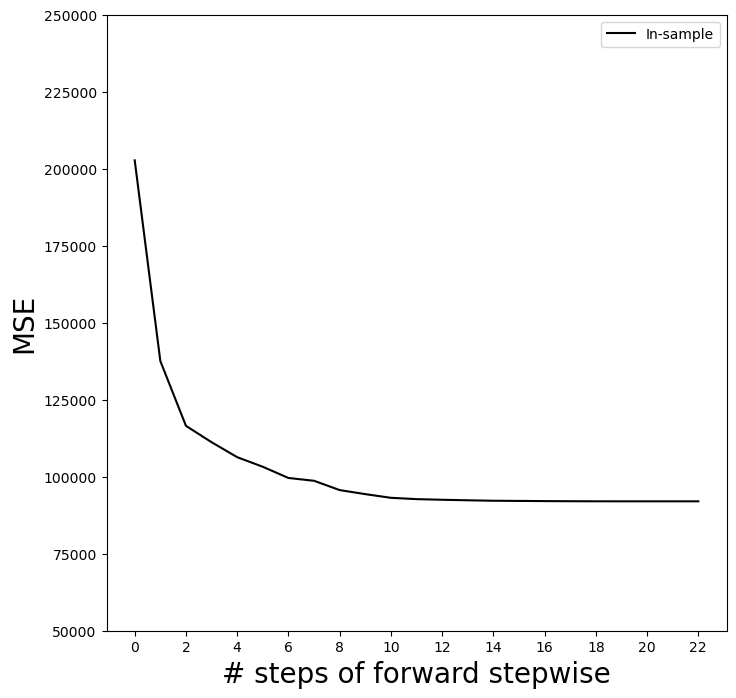

In [20]:
mse_fig, ax = subplots(figsize=(8, 8))              # Create a figure and axis for plotting with a specified figure size of 8x8 inches
insample_mse = ((Yhat_in - Y[:, None])**2).mean(0)  # Compute the mean squared error (MSE) for each step of the forward stepwise selection
n_steps = insample_mse.shape[0]                     # Determine the number of steps in the forward stepwise process
ax.plot(
    np.arange(n_steps),  # X-axis: range of steps
    insample_mse,        # Y-axis: MSE values
    'k',                 # Color: black
    label='In-sample'    # Label for the plot
)
ax.set_ylabel(
    'MSE',               # Y-axis label
    fontsize=20          # Font size for the Y-axis label
)
ax.set_xlabel(
    '# steps of forward stepwise',  # X-axis label
    fontsize=20                     # Font size for the X-axis label
)
ax.set_xticks(np.arange(n_steps)[::2])  # Set X-axis ticks to show every other step
ax.legend()                             # Display the legend for the plot
ax.set_ylim([50000, 250000]);           # Set the Y-axis limits to range from 50,000 to 250,000

Notice the expression None in Y[:,None] above. This adds an axis (dimension) to the one-dimensional array Y, which allows it to be recycled when
subtracted from the two-dimensional Yhat_in.

We are now ready to use cross-validation to estimate test error along
the model path. We must use only the training observations to perform
all aspects of model-fitting — including variable selection. Therefore, the
determination of which model of a given size is best must be made using
only the training observations in each training fold. This point is subtle but
important. If the full data set is used to select the best subset at each step,
then the validation set errors and cross-validation errors that we obtain
will not be accurate estimates of the test error.

We now compute the cross-validated predicted values using 5-fold crossvalidation.

In [21]:
K = 5                # Number of folds for cross-validation

kfold = skm.KFold(
    K,               # Number of splits (folds)
    random_state=0,  # Seed for random number generator to ensure reproducibility
    shuffle=True     # Whether to shuffle the data before splitting into batches
)
Yhat_cv = skm.cross_val_predict(
    full_path,       # Model selection path to be evaluated
    hitters,         # Input feature matrix
    Y,               # Target variable
    cv=kfold         # Cross-validation strategy
)
Yhat_cv.shape        # Get the shape of the cross-validated predictions array

(263, 23)

The prediction matrix Yhat_cv is the same shape as Yhat_in; the difference is that the predictions in each row, corresponding to a particular sample
index, were made from models fit on a training fold that did not include that row.

At each model along the path, we compute the MSE in each of the crossvalidation folds. These we will average to get the mean MSE, and can also
use the individual values to compute a crude estimate of the standard error of the mean. Hence we must know the test indices for each cross-validation
split. This can be found by using the `split()` method of kfold. Because we fixed the random state above, whenever we split any array with the same
number of rows as Y we recover the same training and test indices, though we simply ignore the training indices below.

In [22]:
cv_mse = []  # Initialize an empty list to store cross-validation MSE values

for train_idx, test_idx in kfold.split(Y):               # Iterate over the splits created by KFold
    errors = (Yhat_cv[test_idx] - Y[test_idx, None])**2  # Compute squared errors for the test set
    cv_mse.append(errors.mean(0))                        # Calculate mean squared error for each test set and append to the list

cv_mse = np.array(cv_mse).T  # Convert list of MSE values to a NumPy array and transpose it
cv_mse.shape                 # Get the shape of the cross-validation MSE array

(23, 5)

We now add the cross-validation error estimates to our MSE plot. We
include the mean error across the five folds, and the estimate of the standard
error of the mean.

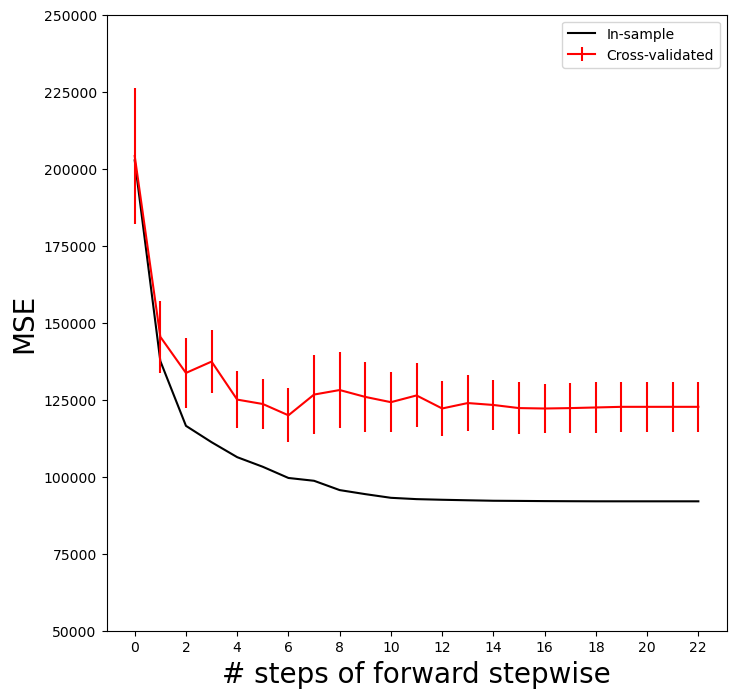

In [23]:
ax.errorbar(
    np.arange(n_steps),          # X-axis values: number of steps in forward stepwise
    cv_mse.mean(1),              # Mean cross-validated MSE values for each step
    cv_mse.std(1) / np.sqrt(K),  # Standard error of the mean for cross-validated MSE values
    label='Cross-validated',     # Label for the error bar plot
    c='r'                        # Color of the error bars: red
) 
ax.set_ylim([50000, 250000])  # Set the y-axis limits for the plot
ax.legend()                   # Display the legend for the plot
mse_fig                       # Display the figure with the error bars

To repeat the above using the validation set approach, we simply change
our cv argument to a validation set: one random split of the data into a
test and training. We choose a test size of 20%, similar to the size of each
test set in 5-fold cross-validation.

In [25]:
validation = skm.ShuffleSplit(  # Create a ShuffleSplit object for validation
    n_splits=1,                 # Number of re-shuffling and splitting iterations
    test_size=0.2,              # Proportion of the data to include in the test split
    random_state=0              # Seed for the random number generator
)

# Iterate over the train-test splits generated by ShuffleSplit
for train_idx, test_idx in validation.split(Y):
    
    # Fit the model on the training data
    full_path.fit(hitters.iloc[train_idx],  # Training feature matrix
                  Y[train_idx])             # Training target variable
    
    # Predict on the validation data
    Yhat_val = full_path.predict(hitters.iloc[test_idx])  # Predicted values on the test set
    
    # Calculate the mean squared error (MSE) for the validation predictions
    errors = (Yhat_val - Y[test_idx, None])**2    # Squared errors between predictions and actual values
    validation_mse = errors.mean(0)               # Mean MSE across all features

As for the in-sample MSE case, the validation set approach does not provide standard errors.

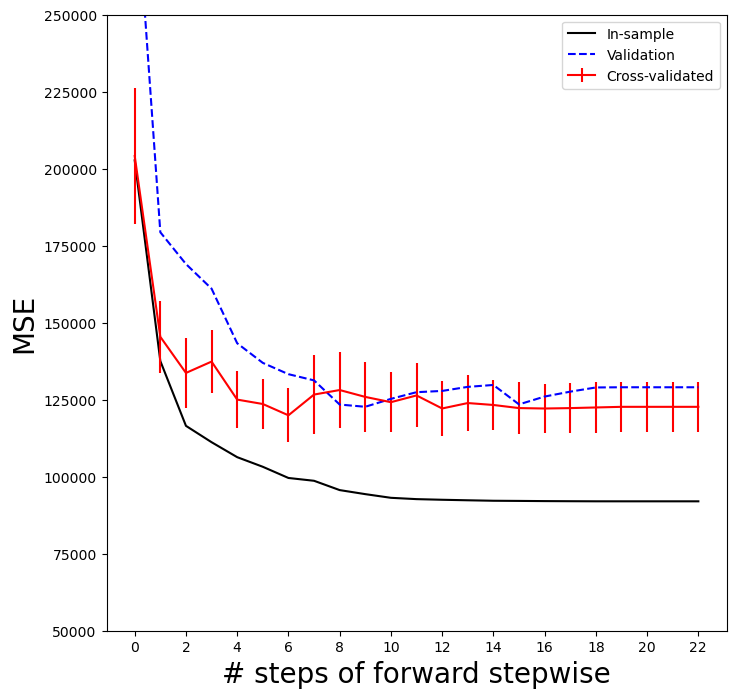

In [26]:
ax.plot(np.arange(n_steps),   # X-axis: number of steps
        validation_mse,       # Y-axis: validation mean squared error
        'b--',                # Line style: blue dashed line
        label='Validation')   # Label for the validation curve in the legend

# Set x-axis ticks to every other step
ax.set_xticks(np.arange(n_steps)[::2])

# Set y-axis limits for the plot
ax.set_ylim([50000, 250000])

# Add a legend to the plot
ax.legend()

# Display the figure
mse_fig

#### Best Subset Selection
Forward stepwise is a greedy selection procedure; at each step it augments
the current set by including one additional variable. We now apply best
subset selection to the Hitters data, which for every subset size, searches
for the best set of predictors.

We will use a package called l0bnb to perform best subset selection.
Instead of constraining the subset to be a given size, this package produces a
path of solutions using the subset size as a penalty rather than a constraint.
Although the distinction is subtle, the difference comes when we cross-validate.

In [28]:
D = design.fit_transform(hitters)  # Apply the design matrix transformation to the Hitters dataset

D = D.drop('intercept', axis=1)    # Drop the 'intercept' column from the transformed design matrix

X = np.asarray(D)                  # Convert the DataFrame to a NumPy array

Here we excluded the first column corresponding to the intercept, as l0bnb
will fit the intercept separately. We can find a path using the `fit_path()`
function.

In [29]:
path = fit_path(
    X,                        # Input feature matrix
    Y,                        # Target variable
    max_nonzeros=X.shape[1]   # Maximum number of non-zero coefficients to consider in the path
)

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  19
Iteration: 10. Number of non-zeros:  22


The function `fit_path()` returns a list whose values include the fitted coefficients as B, an intercept as B0, as well as a few other attributes related to the particular path algorithm used.

In [30]:
path[3]  # Accesses the fourth element in the path

{'B': array([0.        , 3.25500932, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.67766637, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ]),
 'B0': -39.045691558997305,
 'lambda_0': 0.01141749374070153,
 'M': 0.5829383246254924,
 'Time_exceeded': False}

In the example above, we see that at the fourth step in the path, we have
two nonzero coefficients in 'B', corresponding to the value 0.114 for the
penalty parameter lambda_0. We could make predictions using this sequence
of fits on a validation set as a function of lambda_0, or with more work using
cross-validation.

In [36]:
from sklearn.linear_model import ElasticNet

# Standardize X
s = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = s / X_scale[None,:]

# Define lambdas
lambdas = 10**np.linspace(8, -2, 100) / Y.std()

# Perform ElasticNet path with L1 regularization (e.g., l1_ratio=0.5)
soln_array = ElasticNet(l1_ratio=0.5, max_iter=10000).path(Xs, Y, alphas=lambdas)[1]

# Check shape of solution array
soln_array.shape


(22, 100)

In [37]:
from sklearn.linear_model import ElasticNet

# Standardize X
s = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = s / X_scale[None,:]

# Define lambdas
lambdas = 10**np.linspace(8, -2, 100) / Y.std()

# Create ElasticNet object with increased number of iterations
elastic_net = ElasticNet(l1_ratio=0.5, max_iter=10000)  # Increased max_iter

# Perform ElasticNet path
soln_array = elastic_net.path(Xs, Y, alphas=lambdas)[1]

# Check shape of solution array
soln_array.shape

(22, 100)

Here we extract the array of coefficients corresponding to the solutions along the regularization path.
By default the `skl.ElasticNet.path` method fits a path along
an automatically selected range of $\lambda$ values, except for the case when
`l1_ratio=0`, which results in ridge regression (as is the case here). {The reason is rather technical; for all models except ridge, we can find the smallest value of $\lambda$ for which all coefficients are zero. For ridge this value is $\infty$.}  So here
we have chosen to implement the function over a grid of values ranging
from $\lambda=10^{8}$ to $\lambda=10^{-2}$ scaled by the standard
deviation of $y$, essentially covering the full range of scenarios
from the null model containing only the intercept, to the least
squares fit.

Associated with each value of $\lambda$ is a vector of ridge
regression coefficients,   that can be accessed by
a column of `soln_array`. In this case, `soln_array` is a $19 \times 100$ matrix, with
19 rows (one for each predictor) and 100
columns (one for each value of $\lambda$).

We transpose this matrix and turn it into a data frame to facilitate viewing and plotting.

In [38]:
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,CWalks,PutOuts,Assists,Errors,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
negative log(lambda),,,,,,,,,,,,,,,,,,,,,
-12.310900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000
-12.078316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000
-11.845732,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000
-11.613147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000
-11.380563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.784613,-290.967472,337.458072,37.640511,-60.183861,-26.825474,134.954201,-16.952538,-389.429920,88.056647,-13.287431,...,-213.412238,78.764113,53.674524,-22.175083,-15.610440,15.638356,29.163984,-29.253683,6.134334,-6.249484
10.017198,-290.995805,337.552081,37.695968,-60.269795,-26.876408,134.976938,-16.898134,-389.769485,87.754875,-13.486640,...,-213.492232,78.764124,53.686043,-22.170110,-15.609598,15.637748,29.161309,-29.251630,6.130867,-6.246886
10.249782,-291.018345,337.626883,37.740064,-60.338154,-26.916904,134.995014,-16.854989,-390.038033,87.513220,-13.645309,...,-213.555929,78.764136,53.695160,-22.166148,-15.608920,15.637260,29.159185,-29.250000,6.128102,-6.244817
